In [1]:
import os
import functions
import models
#import gradcam
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Use the GPU instead of the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define the label maps
dataset_path = '/mnt/ssd/dataset/scardovi/genimage256'
dataset_path = '/home/scardovi/genimage256'

with open(os.path.join(dataset_path, 'imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# training
train_ds = functions.MulticlassGenImage(img_dir=dataset_path, transform=transform)

# validation and testing
val_ground_truth = functions.val_mapping(dataset_path)
val_test_ds= functions.MulticlassGenImage(img_dir=dataset_path, val_gt=val_ground_truth, transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['generator']}{label['multiclass']}" for label in val_test_ds.img_labels]
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

cuda:0




 - multiclass_finetuning_v2_batch64
- Epoch 1: current lr = 1e-03
Train error: Combined=47.16%; Multiclass=39.69%; Generator=9.94%; 
Validation error: Combined=43.01%;  Multiclass=37.39%; Generator=7.89%; 
Train loss: 3.004e+00; Val loss: 1.884e+00
- Epoch 2: current lr = 1e-03
Train error: Combined=44.38%; Multiclass=37.09%; Generator=9.31%; 
Validation error: Combined=42.83%;  Multiclass=36.08%; Generator=8.89%; 
Train loss: 2.134e+00; Val loss: 1.800e+00
- Epoch 3: current lr = 1e-03
Train error: Combined=41.84%; Multiclass=35.12%; Generator=8.48%; 
Validation error: Combined=41.94%;  Multiclass=35.10%; Generator=9.09%; 
Train loss: 1.931e+00; Val loss: 1.741e+00
- Epoch 4: current lr = 1e-03
Train error: Combined=40.69%; Multiclass=34.04%; Generator=8.11%; 
Validation error: Combined=42.24%;  Multiclass=35.35%; Generator=8.98%; 
Train loss: 1.806e+00; Val loss: 1.732e+00
- Epoch 5: current lr = 1e-03
Train error: Combined=38.73%; Multiclass=32.78%; Generator=7.16%; 
Validation er

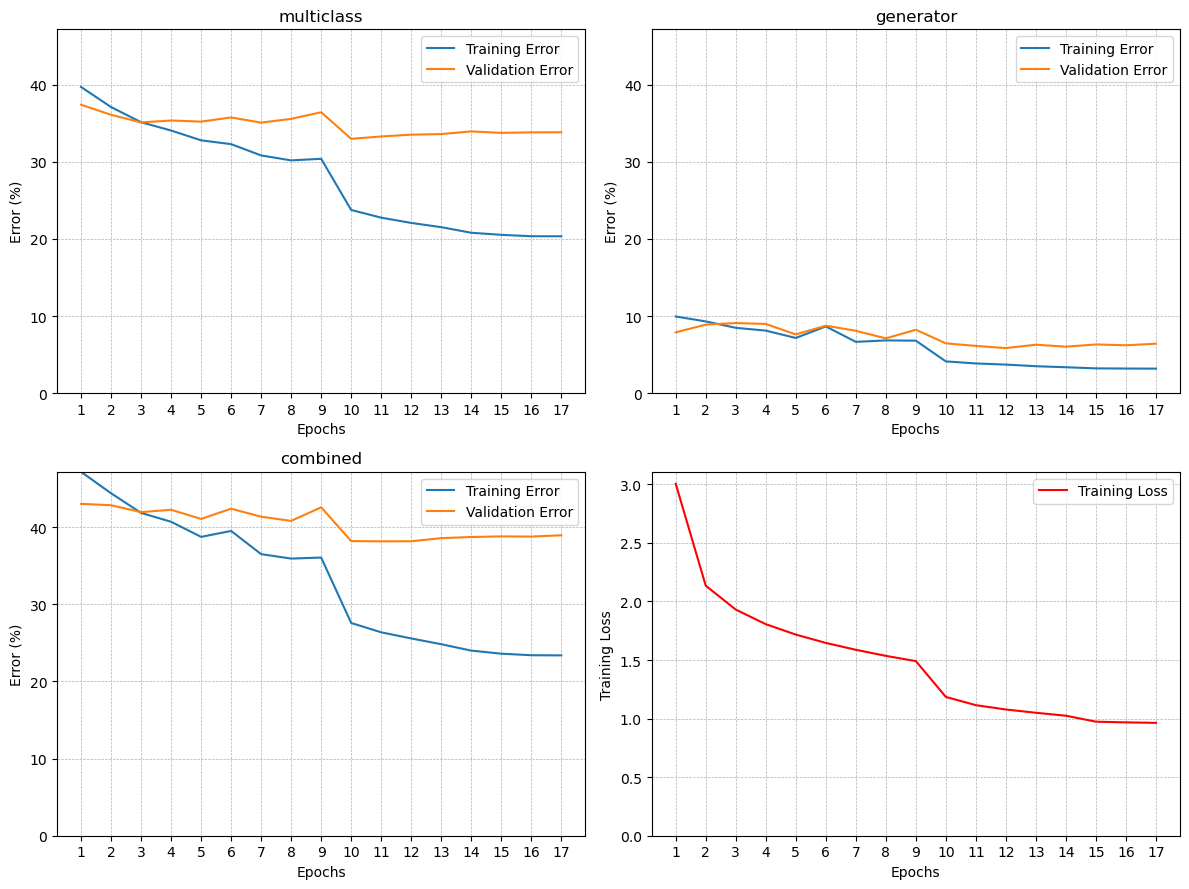

In [3]:
model_init_function = models.multiclass_finetuning
epochs = 20
min_epochs = 10
batch_size = 64
stopping_patience = 5
scheduler_patience = 3
lr = 0.001
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_v2_batch{batch_size}"
print("\n\n - " + model_name)
writer = SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=scheduler_patience, min_epochs=min_epochs, stopping_patience=stopping_patience)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['generator'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

model_init_function = models.multiclass_finetuning
weights_filename = 'multiclass_finetuning_v2_batch64_epochs17.pth'

# Load the model and the test data
model = model_init_function()
model.load_state_dict(torch.load(os.path.join('./weights', weights_filename)))
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

size = {'multiclass': 1000, 'generator': 9}

# Plot the confusion matrix
errors, mAPs = functions.multioutput_error_and_map(device, model, test_loader, size)
print(f'errors: {errors*100:.2f}%')
print(f'mAPs: {errors*100:.2f}')

In [4]:
model_init_function = models.multiclass_finetuning
model = model_init_function()
model = model.to(device)
test_dl = DataLoader(validation_ds, batch_size=64)
weights_filename = "multiclass_finetuning_v2_batch64_epochs17.pth"
model.load_state_dict(torch.load(os.path.join('./weights', weights_filename)))

errors, mAPs = functions.multioutput_accuracy_map(device, model, test_dl, {"generator":9,"multiclass":1000})
print(" Errors")
for x in errors:
    print(f"{x}: {errors[x]*100:.2f}%")
print("\n mAPs")
for x in mAPs:
    print(f"{x}: {mAPs[x]*100:.2f}%")

 Errors
multiclass: 33.82%
generator: 6.42%
combined: 38.94%

 mAPs
multiclass: 42.40%
generator: 84.43%
